In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [ ]:
IMAGE_SHAPE = (224, 224) #This is default shape for inceptionV3

In [ ]:
import pathlib

data_file = "/content/Datasets"

data_root = pathlib.Path(data_file).with_suffix('')

In [ ]:
data_root

PosixPath('/content/Datasets')

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=82,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=82,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 450 files belonging to 3 classes.
Using 360 files for training.
Found 450 files belonging to 3 classes.
Using 90 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['20225016' '20225017' '20225022']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
#TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4" #inceptionv3

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False) #very important to set trainable to false to freeze

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [ ]:
def triplet_loss(anchor, positive, negative, margin=1.0):
  positive_distance = tf.math.reduce_sum(tf.math.square(anchor - positive))
  negative_distance = tf.math.reduce_sum(tf.math.square(anchor - negative))
  loss = tf.math.maximum(0.0, positive_distance - negative_distance + margin)
  return loss


In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,  #base layer
  keras.layers.Dense(128, activation="relu")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21808931 (83.19 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
NUM_EPOCHS = 3

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/3
12/12 [==============================] - 20s 1s/step - loss: 9.2288 - acc: 0.5028 - val_loss: 1.3930 - val_acc: 0.9000
Epoch 2/3
12/12 [==============================] - 8s 723ms/step - loss: 1.0769 - acc: 0.8444 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3/3
12/12 [==============================] - 7s 649ms/step - loss: 0.0810 - acc: 0.9861 - val_loss: 4.7752e-05 - val_acc: 1.0000


In [ ]:
grace_hopper = "/content/Datasets/20225017/126.jpg"
grace_hopper = Image.open(grace_hopper).resize((224, 224))

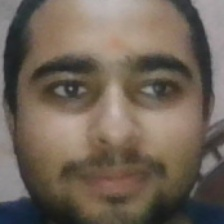

In [ ]:
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 30ms/step


(1, 3)

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
imagenet_labels = ["20225016","20225017","20225022"]

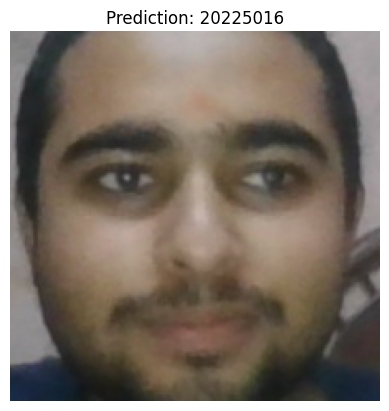

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())